<a href="https://colab.research.google.com/github/Samridh29/Image_colorisation-GANS/blob/main/ImageColourization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:

import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from keras.layers import Input,Dense,Reshape,Conv2D,Dropout,multiply,Dot,Concatenate,subtract,ZeroPadding2D
from keras.layers import BatchNormalization,LeakyReLU,Flatten
from keras.layers import Conv2DTranspose as Deconv2d
from keras.models import Model
from keras.optimizers import Adam

from google.colab import files
from keras import backend as K
import smtplib

from sklearn.utils import shuffle
from google.colab import drive




In [51]:
def plot(A,B,C,n):

    samples = [A,B,C]
    fig = plt.figure(figsize=(3,n), dpi = 1000)
    gs = gridspec.GridSpec(3,n)
    g=0
    for i in range(3):
        for j in range(n):
            ax = plt.subplot(gs[g])
            g+=1
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            if samples[i][j].shape == (32,32,1):
              plt.imshow(samples[i][j].reshape(32, 32) )
            else:
              plt.imshow(samples[i][j].reshape(32,32,3))

    return fig

In [30]:
#for plotting any two images in case

def ploty(A,B,n):

    samples = [A,B]
    fig = plt.figure(figsize=(3,n))
    gs = gridspec.GridSpec(3,n)
    g=0
    for i in range(2):
        for j in range(n):
            ax = plt.subplot(gs[g])
            g+=1
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            if samples[i][j].shape == (32,32,1):
              plt.imshow(samples[i][j].reshape(32, 32, 1))
            else:
              plt.imshow(samples[i][j].reshape(32,32,3))

    return fig

In [31]:
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [32]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y=x_train
x=np.sum(y, axis=3)/(3*255)

y_test=x_test
x_test=np.sum(x_test, axis=3)/(3*255)   #for converting RGB into singe channel
x_test=x_test.reshape(10000, 32, 32, 1)


y=x_train/255
y=y*2-1


#x=x*2-1
#x=np.dot(y[...,:3], [0.299, 0.587, 0.114])/255
#x=x.reshape(50000,32, 32,1)

x=x.reshape(50000, 32, 32, 1)

print(x.shape)
print(y.shape)
  

(50000, 32, 32, 1)
(50000, 32, 32, 3)


In [33]:
  
x_shape=(32,32,1)
y_shape=(32,32,3)

In [34]:
def Generator():
  X = Input(shape = x_shape)
  
  #C1 = ZeroPadding2D(padding=(1,1))(X)  
  C1 = Conv2D(64,kernel_size = 1, strides = 1,input_shape = x_shape)(X)
  C1 = LeakyReLU(0.2)(C1)
  
  C2 = Conv2D(128,kernel_size = 2, strides = 2)(C1)  
  C2 = LeakyReLU(0.2)(C2)
  
  C3 = Conv2D(256,kernel_size = 2, strides = 2)(C2)
  C3 = LeakyReLU(0.2)(C3)
  
  C4 = Conv2D(512,kernel_size = 2, strides = 2)(C3)
  C4 = LeakyReLU(0.2)(C4)

  C5 = Conv2D(512, kernel_size = 2, strides = 2)(C4)
  C5 = LeakyReLU(0.2)(C5)
  
  
  DC0 = Deconv2d(512, kernel_size = 2, strides = 2)(C5)
  DC0 = LeakyReLU(0.2)(DC0)
  DC0 = BatchNormalization()(DC0)
  DC0 = Dropout(0.5)(DC0)
  DC0 = Concatenate(axis=3)([DC0, C4])

  
  DC1 = Deconv2d(256,kernel_size=2, strides = 2)(DC0)
  DC1 = LeakyReLU(0.2)(DC1)
  DC1 = BatchNormalization()(DC1)  
  DC1 = Dropout(0.5)(DC1)             
  DC1 = Concatenate(axis=3)([DC1,C3])

  
  DC2 = Deconv2d(128,kernel_size=2, strides = 2)(DC1)
  DC2 = LeakyReLU(0.2)(DC2)
  DC2 = BatchNormalization()(DC2)  
  DC2 = Concatenate(axis=3)([DC2,C2])
  
  DC3 = Deconv2d(64,kernel_size=2, strides = 2)(DC2)
  DC3 = LeakyReLU(0.2)(DC3)
  DC3 = BatchNormalization()(DC3)  
  DC3 = Concatenate(axis=3)([DC3,C1])
  
  #DC4 = ZeroPadding2D(padding=(3,1))(DC3)  
  CC4 = Conv2D(3,kernel_size=(1, 1), strides = (1, 1), activation="tanh")(DC3)
  
  m = Model(X,CC4)
  m.summary()
  return m
  

In [35]:
def Discriminator():
  X = Input(shape = x_shape)
  Y = Input(shape = y_shape)
  
  In = Concatenate(axis=3)([X,Y])
  
  C1 = Conv2D(64,kernel_size = 2, strides = 2,input_shape = x_shape)(In)
  C1 = BatchNormalization()(C1)
  C1 = LeakyReLU(0.2)(C1)
  C2 = Conv2D(128,kernel_size = 2, strides = 2)(C1)  
  C2 = BatchNormalization()(C2)
  C2 = LeakyReLU(0.2)(C2)
  
  C3 = Conv2D(256,kernel_size = 2, strides = 2)(C2)
  C3 = BatchNormalization()(C3)
  C3 = LeakyReLU(0.2)(C3)
  
  C4 = Conv2D(512,kernel_size = 1, strides = 1)(C3)
  C4 = BatchNormalization()(C4)
  C4 = LeakyReLU(0.2)(C4)
  
  D = Flatten()(C4)
  D = Dense(128)(D)
  D = Dense(1,activation='sigmoid')(D)
  
  m = Model([X,Y],D)
  m.summary()
  return m
   



In [36]:
X = Input(shape = x_shape)
Y = Input(shape = y_shape)

gen = Generator()
dis = Discriminator()

out = gen(X)
comb = dis([X,out])

out = Flatten()(out)
org = Flatten()(Y)

cos_dis = Dot(axes = 1,normalize = True)([out,org])

combined = Model([X,Y],[comb,cos_dis])

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 32, 32, 64)   128         ['input_13[0][0]']               
                                                                                                  
 leaky_re_lu_26 (LeakyReLU)     (None, 32, 32, 64)   0           ['conv2d_20[0][0]']              
                                                                                                  
 conv2d_21 (Conv2D)             (None, 16, 16, 128)  32896       ['leaky_re_lu_26[0][0]']         
                                                                                            

In [37]:
genLoss=[]
disLoss=[]

In [55]:
epochs = 80
batch_size = 64
n_example = 15000
batches = int(n_example/batch_size)
dis_updates = 2
gen_updates = 1
zero=np.zeros((batch_size,1))
one=np.ones((batch_size,1))*0.9
d_loss_factor = batches*2*dis_updates
g_loss_factor = batches*gen_updates
reuse = False
adams = Adam(lr = 0.0001)

In [56]:
#location in drive where models are present.

if(reuse == True):
  gen.load_weights("gdrive/My Drive/newGAN/Generator.h5")
  dis.load_weights("gdrive/My Drive/newGAN/Discriminator.h5")

##############
For Epoch:0
Training Discriminator
2/2 [==============================] - 0s 13ms/step
Training Generator
Discriminator Loss:0.16734057440319305
Generator loss:0.684271118325046
1/1 [==============================] - 0s 18ms/step


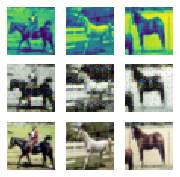

##############
For Epoch:1
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.1673126004965074
Generator loss:0.6821094333616078
1/1 [==============================] - 0s 17ms/step


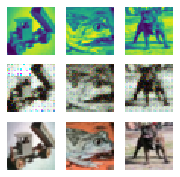

##############
For Epoch:2
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16653467651236947
Generator loss:0.6853479223373609
1/1 [==============================] - 0s 19ms/step


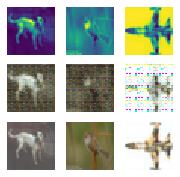

##############
For Epoch:3
Training Discriminator
2/2 [==============================] - 0s 13ms/step
Training Generator
Discriminator Loss:0.16444050588001524
Generator loss:0.6819298486424308
1/1 [==============================] - 0s 19ms/step


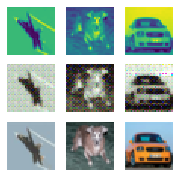

##############
For Epoch:4
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.1650047142368119
Generator loss:0.6786413921250237
1/1 [==============================] - 0s 24ms/step


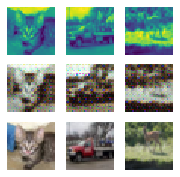

##############
For Epoch:5
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.1643792218251953
Generator loss:0.6749554717133188
1/1 [==============================] - 0s 17ms/step


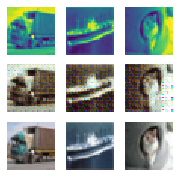

##############
For Epoch:6
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.1636321548306495
Generator loss:0.6802116945768014
1/1 [==============================] - 0s 19ms/step


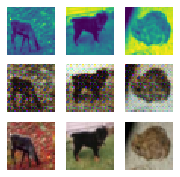

##############
For Epoch:7
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16377518270544694
Generator loss:0.6772766077620351
1/1 [==============================] - 0s 17ms/step


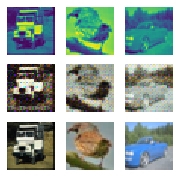

##############
For Epoch:8
Training Discriminator
2/2 [==============================] - 0s 13ms/step
Training Generator
Discriminator Loss:0.16377075140075575
Generator loss:0.6767103771368662
1/1 [==============================] - 0s 17ms/step


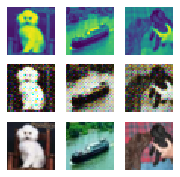

##############
For Epoch:9
Training Discriminator
2/2 [==============================] - 0s 14ms/step
Training Generator
Discriminator Loss:0.16348756408301712
Generator loss:0.674656854226039
1/1 [==============================] - 0s 32ms/step


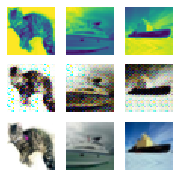

##############
For Epoch:10
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16380080829050836
Generator loss:0.6805852529330131
1/1 [==============================] - 0s 22ms/step


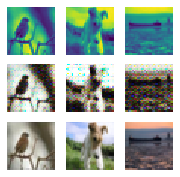

##############
For Epoch:11
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.16359927721272952
Generator loss:0.6758983178525908
1/1 [==============================] - 0s 21ms/step


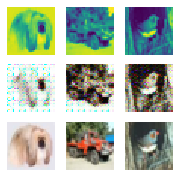

##############
For Epoch:12
Training Discriminator
2/2 [==============================] - 0s 14ms/step
Training Generator
Discriminator Loss:0.16337813115605734
Generator loss:0.6763160312787081
1/1 [==============================] - 0s 20ms/step


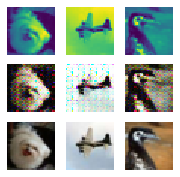

##############
For Epoch:13
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.16348911740408215
Generator loss:0.6749818401458936
1/1 [==============================] - 0s 19ms/step


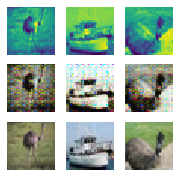

##############
For Epoch:14
Training Discriminator
2/2 [==============================] - 0s 16ms/step
Training Generator
Discriminator Loss:0.16339827744075155
Generator loss:0.6742410629223554
1/1 [==============================] - 0s 24ms/step


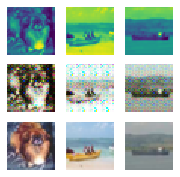

##############
For Epoch:15
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.16315312910670307
Generator loss:0.6747796813137511
1/1 [==============================] - 0s 18ms/step


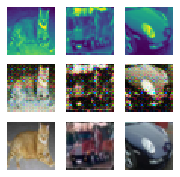

##############
For Epoch:16
Training Discriminator
2/2 [==============================] - 0s 13ms/step
Training Generator
Discriminator Loss:0.16310799183138364
Generator loss:0.6747005752518646
1/1 [==============================] - 0s 19ms/step


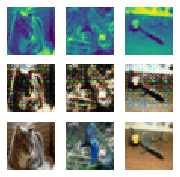

##############
For Epoch:17
Training Discriminator
2/2 [==============================] - 0s 13ms/step
Training Generator
Discriminator Loss:0.16328693593938554
Generator loss:0.679519756227477
1/1 [==============================] - 0s 19ms/step


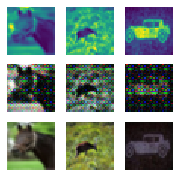

##############
For Epoch:18
Training Discriminator
2/2 [==============================] - 0s 14ms/step
Training Generator
Discriminator Loss:0.1631526129590442
Generator loss:0.6790673363412547
1/1 [==============================] - 0s 22ms/step


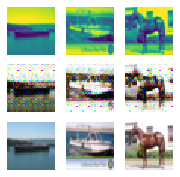

##############
For Epoch:19
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16379727415315778
Generator loss:0.6867153799941397
1/1 [==============================] - 0s 23ms/step


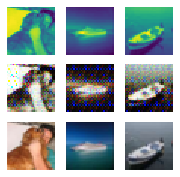

##############
For Epoch:20
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.16321199088681682
Generator loss:0.6782723196551331
1/1 [==============================] - 0s 22ms/step


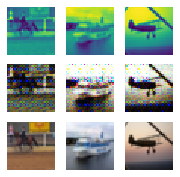

##############
For Epoch:21
Training Discriminator
2/2 [==============================] - 0s 18ms/step
Training Generator
Discriminator Loss:0.1631113199507484
Generator loss:0.6777152938720508
1/1 [==============================] - 0s 20ms/step


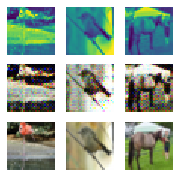

##############
For Epoch:22
Training Discriminator
2/2 [==============================] - 0s 15ms/step
Training Generator
Discriminator Loss:0.1630811027292803
Generator loss:0.6786174618790293
1/1 [==============================] - 0s 17ms/step


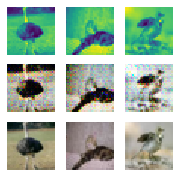

##############
For Epoch:23
Training Discriminator
2/2 [==============================] - 0s 16ms/step
Training Generator
Discriminator Loss:0.1630489633176562
Generator loss:0.676583899392022
1/1 [==============================] - 0s 17ms/step


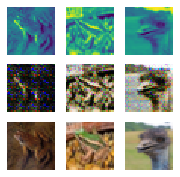

##############
For Epoch:24
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16304049663200848
Generator loss:0.6748929186763927
1/1 [==============================] - 0s 18ms/step


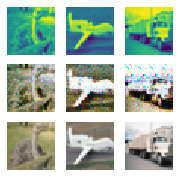

##############
For Epoch:25
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.1629758932070054
Generator loss:0.6726869624904078
1/1 [==============================] - 0s 19ms/step


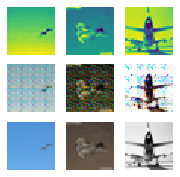

##############
For Epoch:26
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.16294875610782406
Generator loss:0.6702543891902663
1/1 [==============================] - 0s 17ms/step


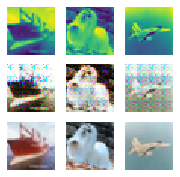

##############
For Epoch:27
Training Discriminator
2/2 [==============================] - 0s 13ms/step
Training Generator
Discriminator Loss:0.16287093300264746
Generator loss:0.6716522149041168
1/1 [==============================] - 0s 17ms/step


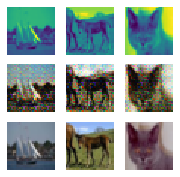

##############
For Epoch:28
Training Discriminator
2/2 [==============================] - 0s 15ms/step
Training Generator
Discriminator Loss:0.1629293724693323
Generator loss:0.6709897765237042
1/1 [==============================] - 0s 21ms/step


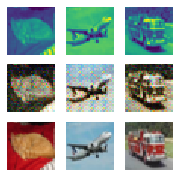

##############
For Epoch:29
Training Discriminator
2/2 [==============================] - 0s 13ms/step
Training Generator
Discriminator Loss:0.16290984228819777
Generator loss:0.6691345164918492
1/1 [==============================] - 0s 20ms/step


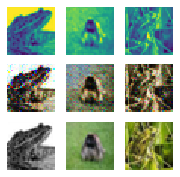

##############
For Epoch:30
Training Discriminator
2/2 [==============================] - 0s 15ms/step
Training Generator
Discriminator Loss:0.162874508042781
Generator loss:0.6689315033264649
1/1 [==============================] - 0s 20ms/step


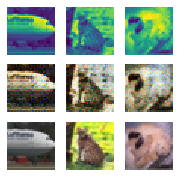

##############
For Epoch:31
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.1637141064582574
Generator loss:0.671540307183551
1/1 [==============================] - 0s 27ms/step


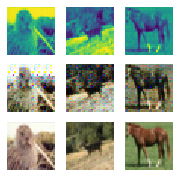

##############
For Epoch:32
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.16281376128788977
Generator loss:0.6686199062909836
1/1 [==============================] - 0s 20ms/step


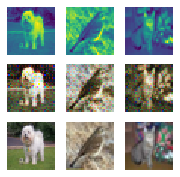

##############
For Epoch:33
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.16288337509233206
Generator loss:0.6683731777036291
1/1 [==============================] - 0s 18ms/step


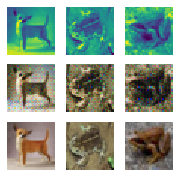

##############
For Epoch:34
Training Discriminator
2/2 [==============================] - 0s 16ms/step
Training Generator
Discriminator Loss:0.16286822000704645
Generator loss:0.6671620299164046
1/1 [==============================] - 0s 18ms/step


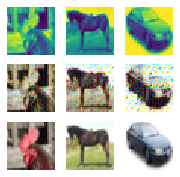

##############
For Epoch:35
Training Discriminator
2/2 [==============================] - 0s 15ms/step
Training Generator
Discriminator Loss:0.16282921364065966
Generator loss:0.667491474467465
1/1 [==============================] - 0s 18ms/step


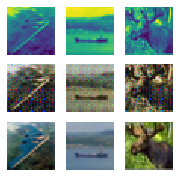

##############
For Epoch:36
Training Discriminator
2/2 [==============================] - 0s 14ms/step
Training Generator
Discriminator Loss:0.16281725483363477
Generator loss:0.6668570268357921
1/1 [==============================] - 0s 17ms/step


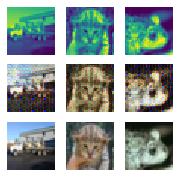

##############
For Epoch:37
Training Discriminator
2/2 [==============================] - 0s 15ms/step
Training Generator
Discriminator Loss:0.16288232570849898
Generator loss:0.6674485484249572
1/1 [==============================] - 0s 17ms/step


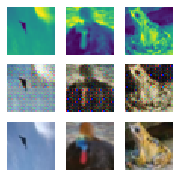

##############
For Epoch:38
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.16283635376994504
Generator loss:0.6660303784231855
1/1 [==============================] - 0s 20ms/step


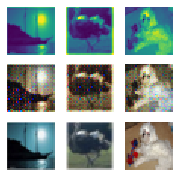

##############
For Epoch:39
Training Discriminator
2/2 [==============================] - 0s 14ms/step
Training Generator
Discriminator Loss:0.1628059447753625
Generator loss:0.6649137473004496
1/1 [==============================] - 0s 23ms/step


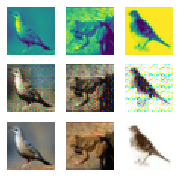

##############
For Epoch:40
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.1628504512007374
Generator loss:0.6710095392842578
1/1 [==============================] - 0s 18ms/step


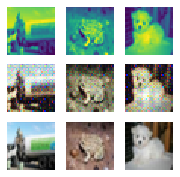

##############
For Epoch:41
Training Discriminator
2/2 [==============================] - 0s 20ms/step
Training Generator
Discriminator Loss:0.16275932164094384
Generator loss:0.6668669833586767
1/1 [==============================] - 0s 18ms/step


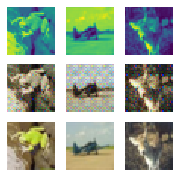

##############
For Epoch:42
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.16277838123382993
Generator loss:0.6648366560793331
1/1 [==============================] - 0s 18ms/step


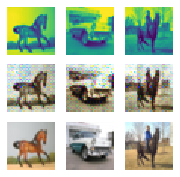

##############
For Epoch:43
Training Discriminator
2/2 [==============================] - 0s 15ms/step
Training Generator
Discriminator Loss:0.16274000615762194
Generator loss:0.6645101339389117
1/1 [==============================] - 0s 17ms/step


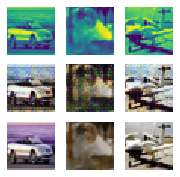

##############
For Epoch:44
Training Discriminator
2/2 [==============================] - 0s 18ms/step
Training Generator
Discriminator Loss:0.16277361760211648
Generator loss:0.6645112407003713
1/1 [==============================] - 0s 21ms/step


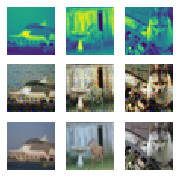

##############
For Epoch:45
Training Discriminator
2/2 [==============================] - 0s 13ms/step
Training Generator
Discriminator Loss:0.16269657775136243
Generator loss:0.664740516589238
1/1 [==============================] - 0s 17ms/step


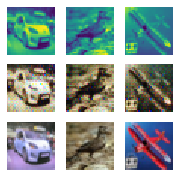

##############
For Epoch:46
Training Discriminator
2/2 [==============================] - 0s 20ms/step
Training Generator
Discriminator Loss:0.16276668540501274
Generator loss:0.6652103509658422
1/1 [==============================] - 0s 20ms/step


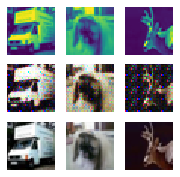

##############
For Epoch:47
Training Discriminator
2/2 [==============================] - 0s 20ms/step
Training Generator
Discriminator Loss:0.16275139679676043
Generator loss:0.6653124690055847
1/1 [==============================] - 0s 18ms/step


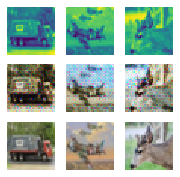

##############
For Epoch:48
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.16280411007733067
Generator loss:0.6649023956722684
1/1 [==============================] - 0s 19ms/step


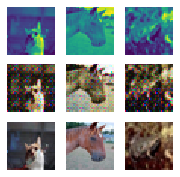

##############
For Epoch:49
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16272881516957202
Generator loss:0.6665024813423809
1/1 [==============================] - 0s 23ms/step


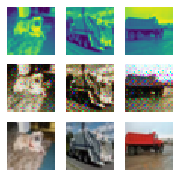

##############
For Epoch:50
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.16270801677422952
Generator loss:0.6643207898506751
1/1 [==============================] - 0s 20ms/step


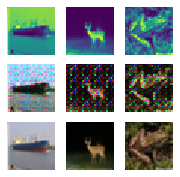

##############
For Epoch:51
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.16271654336731572
Generator loss:0.6637085594682612
1/1 [==============================] - 0s 20ms/step


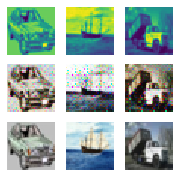

##############
For Epoch:52
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16270001826296915
Generator loss:0.6633364010570396
1/1 [==============================] - 0s 21ms/step


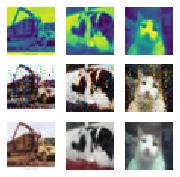

##############
For Epoch:53
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16270231814438574
Generator loss:0.6634190260854542
1/1 [==============================] - 0s 18ms/step


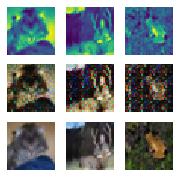

##############
For Epoch:54
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.16267348585083846
Generator loss:0.6657733033355485
1/1 [==============================] - 0s 22ms/step


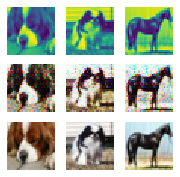

##############
For Epoch:55
Training Discriminator
2/2 [==============================] - 0s 14ms/step
Training Generator
Discriminator Loss:0.16268485187973922
Generator loss:0.6654845384451059
1/1 [==============================] - 0s 21ms/step


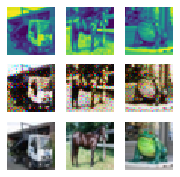

##############
For Epoch:56
Training Discriminator
2/2 [==============================] - 0s 15ms/step
Training Generator
Discriminator Loss:0.16273906651386652
Generator loss:0.6649471977327623
1/1 [==============================] - 0s 17ms/step


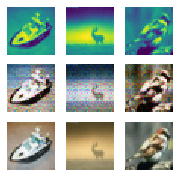

##############
For Epoch:57
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.16270914010588
Generator loss:0.6654812538216257
1/1 [==============================] - 0s 18ms/step


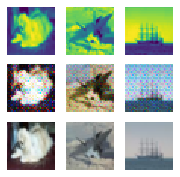

##############
For Epoch:58
Training Discriminator
2/2 [==============================] - 0s 15ms/step
Training Generator
Discriminator Loss:0.1626638368519703
Generator loss:0.6646961681863182
1/1 [==============================] - 0s 26ms/step


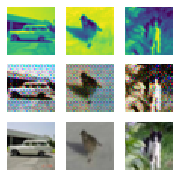

##############
For Epoch:59
Training Discriminator
2/2 [==============================] - 0s 15ms/step
Training Generator
Discriminator Loss:0.16271100661766238
Generator loss:0.6645016761926504
1/1 [==============================] - 0s 17ms/step


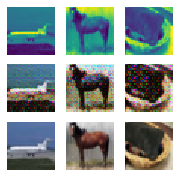

##############
For Epoch:60
Training Discriminator
2/2 [==============================] - 0s 16ms/step
Training Generator
Discriminator Loss:0.16265431722832413
Generator loss:0.6649287918693999
1/1 [==============================] - 0s 21ms/step


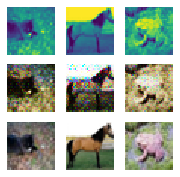

##############
For Epoch:61
Training Discriminator
2/2 [==============================] - 0s 15ms/step
Training Generator
Discriminator Loss:0.162810296379934
Generator loss:0.6641815016921769
1/1 [==============================] - 0s 21ms/step


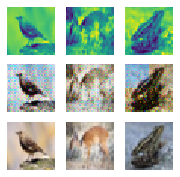

##############
For Epoch:62
Training Discriminator
2/2 [==============================] - 0s 19ms/step
Training Generator
Discriminator Loss:0.16266482480106728
Generator loss:0.6636484313724388
1/1 [==============================] - 0s 19ms/step


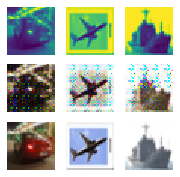

##############
For Epoch:63
Training Discriminator
2/2 [==============================] - 0s 19ms/step
Training Generator
Discriminator Loss:0.1629239212984678
Generator loss:0.6619904112612081
1/1 [==============================] - 0s 19ms/step


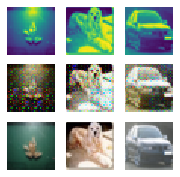

##############
For Epoch:64
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16268575174273178
Generator loss:0.6621679956586952
1/1 [==============================] - 0s 18ms/step


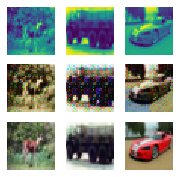

##############
For Epoch:65
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.1626737353876269
Generator loss:0.6611838524158185
1/1 [==============================] - 0s 18ms/step


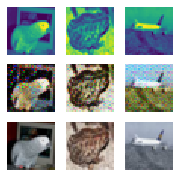

##############
For Epoch:66
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.16264909945323666
Generator loss:0.6612200036517575
1/1 [==============================] - 0s 18ms/step


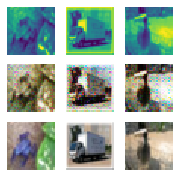

##############
For Epoch:67
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16268216313687017
Generator loss:0.6615067488617368
1/1 [==============================] - 0s 17ms/step


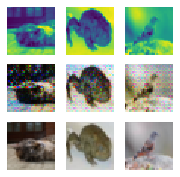

##############
For Epoch:68
Training Discriminator
2/2 [==============================] - 0s 13ms/step
Training Generator
Discriminator Loss:0.162663089825527
Generator loss:0.6617544270478762
1/1 [==============================] - 0s 17ms/step


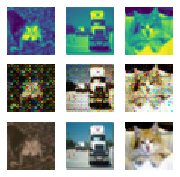

##############
For Epoch:69
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16266353243264428
Generator loss:0.6626604003274542
1/1 [==============================] - 0s 18ms/step


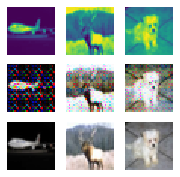

##############
For Epoch:70
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16265300440489258
Generator loss:0.6623889296992213
1/1 [==============================] - 0s 18ms/step


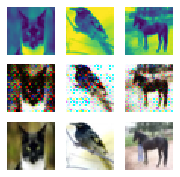

##############
For Epoch:71
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16266058427177144
Generator loss:0.6621451388057481
1/1 [==============================] - 0s 20ms/step


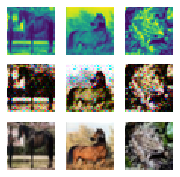

##############
For Epoch:72
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16262918285140598
Generator loss:0.6629864978484619
1/1 [==============================] - 0s 20ms/step


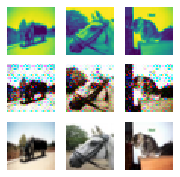

##############
For Epoch:73
Training Discriminator
2/2 [==============================] - 0s 13ms/step
Training Generator
Discriminator Loss:0.1626300596993888
Generator loss:0.6640403668085734
1/1 [==============================] - 0s 21ms/step


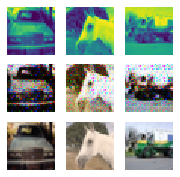

##############
For Epoch:74
Training Discriminator
2/2 [==============================] - 0s 12ms/step
Training Generator
Discriminator Loss:0.16266927453131125
Generator loss:0.663775081308479
1/1 [==============================] - 0s 24ms/step


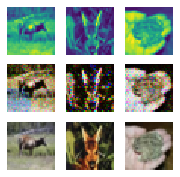

##############
For Epoch:75
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16265931885185964
Generator loss:0.6667867794505551
1/1 [==============================] - 0s 18ms/step


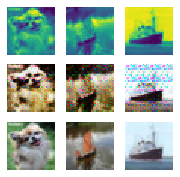

##############
For Epoch:76
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.1626278958136291
Generator loss:0.66736339758604
1/1 [==============================] - 0s 22ms/step


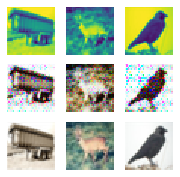

##############
For Epoch:77
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16263500550544605
Generator loss:0.668485364343366
1/1 [==============================] - 0s 30ms/step


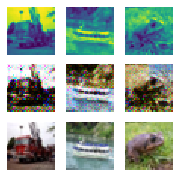

##############
For Epoch:78
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16265247559673857
Generator loss:0.6690061736820091
1/1 [==============================] - 0s 17ms/step


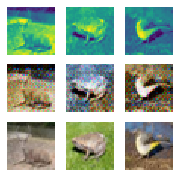

##############
For Epoch:79
Training Discriminator
2/2 [==============================] - 0s 11ms/step
Training Generator
Discriminator Loss:0.16264713388872784
Generator loss:0.6700649939031682
1/1 [==============================] - 0s 17ms/step


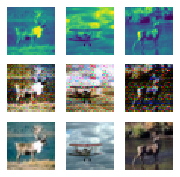

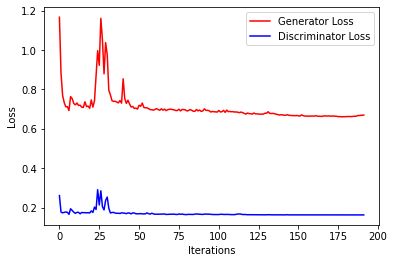

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:

for epoch in range(epochs):
  print("##############")
  print("For Epoch:"+str(epoch))
  
  g_loss = 0
  d_loss = 0
  
  print("Training Discriminator")
  
  i = shuffle(range(n_example))
  
  dis.trainable = True
  dis.compile(loss = "binary_crossentropy",optimizer = adams)
  
  for j in range(dis_updates):
      
    for b in range(batches):
        
      x_batch = x[i[b*batch_size:(b+1)*batch_size]]
      y_batch = y[i[b*batch_size:(b+1)*batch_size]]
      
      pre_batch = gen.predict(x_batch)
      
      d_loss += dis.train_on_batch([x_batch,y_batch],one)
      d_loss += dis.train_on_batch([x_batch,pre_batch],zero)
      
  print("Training Generator")
  
  dis.trainable = False
  combined.compile(loss  = "binary_crossentropy", optimizer = adams)  
  dis.compile(loss = "binary_crossentropy",optimizer = adams)
        
  for  j in range(gen_updates):
    
    for b in range(batches):
      
      x_batch = x[i[b*batch_size:(b+1)*batch_size]]
      y_batch = y[i[b*batch_size:(b+1)*batch_size]]
      
        
      #in case the mode collapse takes place....commenting next two lines might help.
      #if b%4==3:
        #gl,_,_ = combined.train_on_batch([x_batch,y_batch],[zero,one])  
      
      gl,_,_ = combined.train_on_batch([x_batch,y_batch],[one,one])
      g_loss += gl
      
  g_loss /= g_loss_factor
  d_loss /= d_loss_factor
      
  print("Discriminator Loss:"+str(d_loss))
  print("Generator loss:"+str(g_loss))
  
  genLoss.append(g_loss)
  disLoss.append(d_loss)
  
  gen.save_weights("gdrive/My Drive/newGAN/Generator.h5")
  dis.save_weights("gdrive/My Drive/newGAN/Discriminator.h5")
  


  plt_indices = np.random.randint(50000,size=4)
  plt_a = x[plt_indices]
  plt_b = gen.predict(plt_a)
  plt_b = (plt_b+1)/2
  plt_c = (y[plt_indices]+1)/2
  fig = plot(plt_a,plt_b,plt_c,3)
  plt.show()
  plt.close(fig)
 


plt.plot(genLoss, c='r', label="Generator Loss")
plt.plot(disLoss, c='b', label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

files.download('gdrive/My Drive/newGAN/Generator.h5')
files.download('gdrive/My Drive/newGAN/Discriminator.h5')



#for recieving mail on completion of training.
# server = smtplib.SMTP('smtp.gmail.com', 587)
# server.starttls()
# server.login("************@gmail.com", "*********")
 
# msg = "COLAB WORK FINISH ALERT!"
# server.sendmail("***********@gmail.com", "********@nirmauni.ac.in", msg)
# server.quit()
